<a href="https://colab.research.google.com/github/kutluhanNG/MachineLearning/blob/main/Custom_Variational_Autoencoder_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is an example of a Variational Autoencoder (VAE) implemented using TensorFlow 2 (with Keras) in a Jupyter Notebook. This example uses the MNIST dataset to demonstrate how to build, train, and visualize a VAE.



**Importing Libraries and loading data.**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Enable inline plotting in the notebook.
%matplotlib inline

# Load the MNIST dataset.
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten the images.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, [-1, 28 * 28])
x_test = np.reshape(x_test, [-1, 28 * 28])

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 784)
Test set shape: (10000, 784)


**Define Model Parameters and the Reparameterization Trick**

*The VAE consists of an encoder that maps the input to a latent space and a decoder that reconstructs the input. We need to implement the “reparameterization trick” to allow gradients to flow through the stochastic sampling step.*

In [2]:
# Model parameters.
original_dim = 784        # 28 x 28 images flattened
intermediate_dim = 512
latent_dim = 2            # You can set this to a higher value if needed

# Define the sampling function using the reparameterization trick.
def sampling(args):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


**Build the encoder**

*The encoder maps the input image to a latent distribution parameterized by a mean and log variance.*

In [3]:
# Define encoder model.
inputs = layers.Input(shape=(original_dim,), name='encoder_input')
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(h)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(h)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        401,920 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          1,026 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          1,026 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 403,972 (1.54 MB)

 Trainable params: 403,972 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

**Build the decoder**

*The decoder reconstructs the input image from the latent vector.*

In [4]:
# Define decoder model.
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         402,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

**Define the VAE Model and Its Loss Function**

*The VAE loss is a combination of a reconstruction loss (how well the output matches the input) and a KL divergence term (which regularizes the latent space to follow a unit Gaussian).*

In [5]:
# Define a custom VAE model by subclassing tf.keras.Model.
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Encode input to latent space.
        z_mean, z_log_var, z = self.encoder(inputs)
        # Decode the latent representation.
        reconstruction = self.decoder(z)
        # Compute the KL divergence loss.
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        # Optionally, you can also compute a reconstruction loss here.
        # For example, using binary crossentropy (summed over all pixels):
        reconstruction_loss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(inputs, reconstruction), axis=-1
        )
        # Add the KL loss and the reconstruction loss to the model losses.
        self.add_loss(tf.reduce_mean(kl_loss + reconstruction_loss))
        return reconstruction

# Instantiate and compile the VAE.
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())


**Train the VAE**

*Train the VAE using the MNIST training data. In this example, the network is trained to reconstruct its own input.*

In [6]:
epochs = 50
batch_size = 128

history = vae.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 43.5123 - val_loss: 31.1679
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31.1698 - val_loss: 30.5724
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.6416 - val_loss: 30.3411
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.3295 - val_loss: 30.0512
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.1293 - val_loss: 29.8731
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.9717 - val_loss: 29.7435
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.7744 - val_loss: 29.5897
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.6525 - val_loss: 29.6015
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.5823 - val_loss: 29.4908
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.5404 - val_loss: 29.3727
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.4686 - val_loss: 29.3088
Epoch 12/50
469/469 ━━━━━━━━━━

**Visualize the Latent Space**

*After training, you can visualize how the MNIST digits are organized in the 2D latent space. For a latent dimension of 2, you can plot the means for each test example.*

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


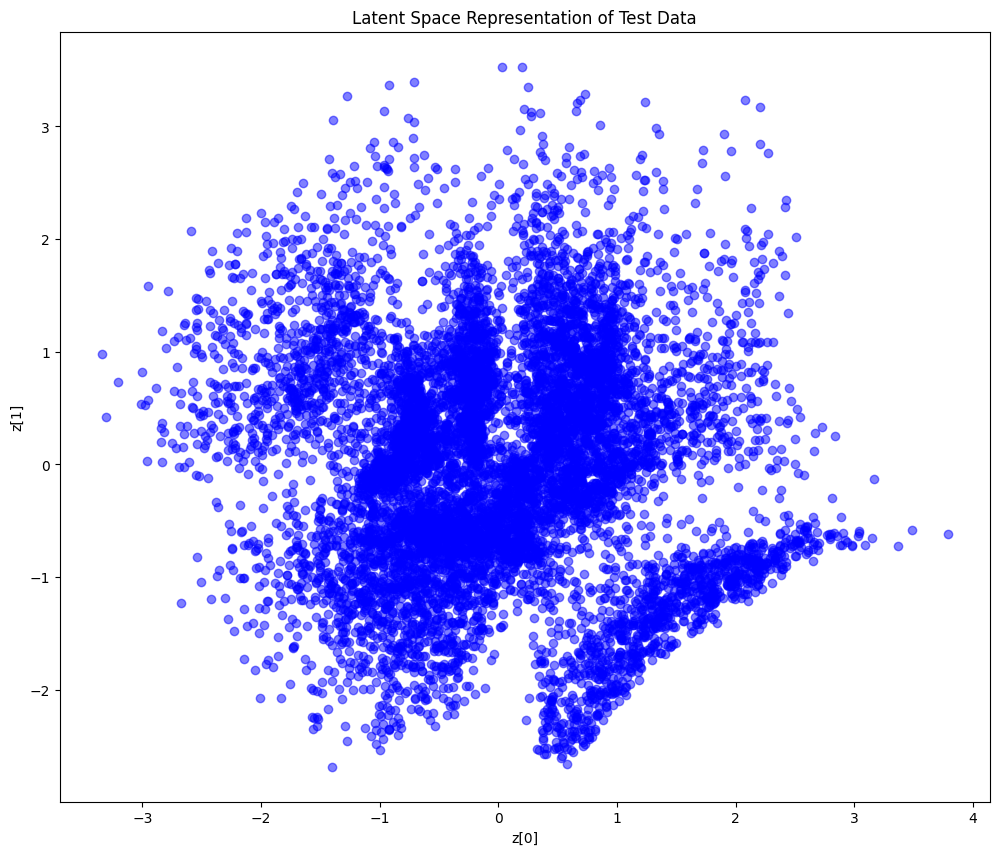

In [7]:
# Obtain the latent means for the test set.
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='blue', alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Representation of Test Data")
plt.show()


**Generate New Digits from the Latent Space**

*You can generate new digits by sampling points in the latent space and passing them through the decoder.*

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

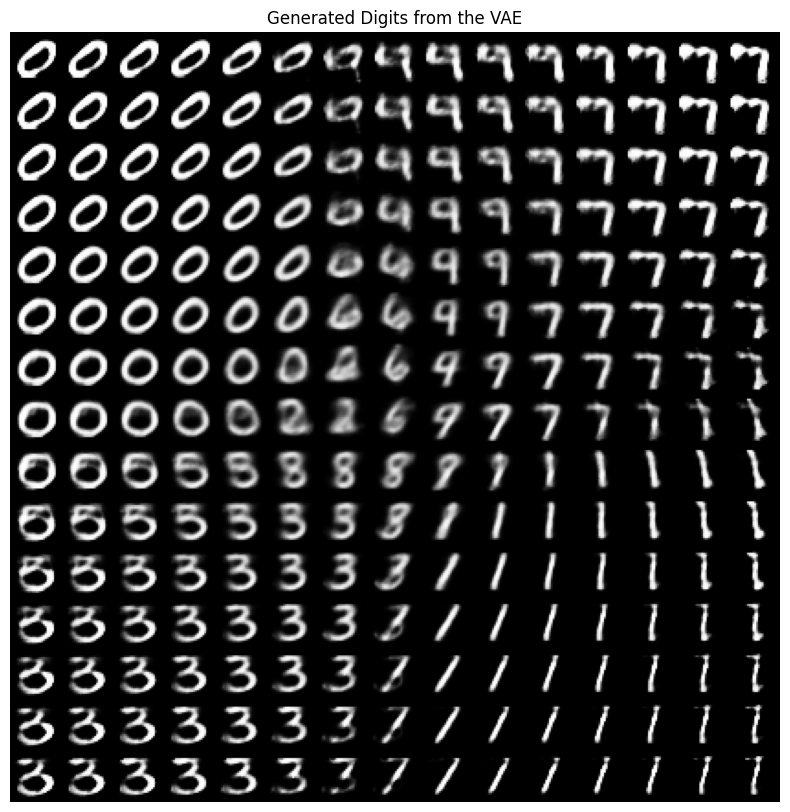

In [8]:
# Display a 2D manifold of digits by sampling over the latent space grid.
n = 15           # Grid size: n x n digits.
digit_size = 28  # MNIST image dimensions.
figure = np.zeros((digit_size * n, digit_size * n))

# Generate grid values between -4 and 4.
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]  # Reverse to have the origin at the top-left.

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title("Generated Digits from the VAE")
plt.axis('Off')
plt.show()
